In [1]:
# 创建类
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

""" 
root_dir/
├── class1/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── class2/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
└── ...
"""
class ImageNet12(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): 包含所有图像的目录路径。
            transform (callable, optional): 可选的图像转换操作。
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                images.append((os.path.join(class_path, img_name), self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [2]:
# 运行

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import pandas as pd

# ================================== 参数设置 ====================================   
# 选择数据集
# dataset_name = 'MNIST'
# dataset_name = 'FashionMNIST'
# dataset_name = 'CIFAR10'
dataset_name = 'ImageNet12'
# dataset_name = 'AgNews'

# 是否后门攻击
# backdoor attack
# backdoor = True 
backdoor = False 
print("backdoor attack: ", backdoor)

# poisioned client portion
poisoned_client_portion = 0.4

# poisioned data portion
poison_data_portion = 0.5
print("poisoned data portion in each client: ", poison_data_portion)

# target label
target_label = 0
print("target label: ", target_label)

num_classes_dict = {"MNIST": 10, "FashionMNIST": 10, "CIFAR10": 10, "ImageNet12": 12, "AgNews": 4}

# 设置数据集的超参数
num_clients = 10

num_classes = num_classes_dict[dataset_name]

iid = True

# iid = False
alpha = 10

# choose which client to poison
comprised_client_idx = list(range(0, int(poisoned_client_portion * num_clients)))
print("poisoned client: ", comprised_client_idx)

# ===============================================================
"""
torchvision.transforms.Normalize 是 PyTorch 中用于图像标准化的一个变换。它接受两个参数：mean 和 std，分别表示每个通道的均值和标准差。标准化的目的是使图像数据的分布更加平滑，从而有助于训练神经网络模型。
"""

CIFAR10_stats = {
    "mean": (0.4914, 0.4822, 0.4465),
    "std": (0.2023, 0.1994, 0.2010),
}

ImageNet12_stats = {
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225],
}


torchvision_transforms = {
    "MNIST": {
        "train": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.1307,), (0.3081,)
                ),  # Normalize the data with mean and std deviation
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.ToTensor(),  # Convert PIL.Image to Tensor
                transforms.Normalize(
                    (0.1307,), (0.3081,)
                ),  # Normalize the data with mean and std deviation
            ]
        ),
    },
    "FashionMNIST": {
        "train": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.5,), (0.5,)
                ),  # Normalizing with mean=0.5 and std=0.5
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.5,), (0.5,)
                ),  # Normalizing with mean=0.5 and std=0.5
            ]
        ),
    },
        "CIFAR10": {
        "train": transforms.Compose(
            [
                transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),  # Convert PIL.Image to Tensor
                transforms.Normalize(
                    mean=CIFAR10_stats["mean"], std=CIFAR10_stats["std"]
                ),
                transforms.RandomErasing(p=0.25),
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.ToTensor(),  # 将PIL.Image转换为张量
                transforms.Normalize(
                    mean=CIFAR10_stats["mean"], std=CIFAR10_stats["std"]
                ),
            ]
        ),
    },
    "ImageNet12": {
        "train": transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=ImageNet12_stats["mean"], std=ImageNet12_stats["std"]
                ),
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=ImageNet12_stats["mean"], std=ImageNet12_stats["std"]
                ),
            ]
        ),
    },
}

default_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

class AGNewsDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.text = self.data['text'].tolist()
        self.labels = self.data['label'].tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.labels[idx]
        return text, label

if  dataset_name == 'MNIST':
    # 加载 MNIST 数据集
    # toTensor() 将 PIL.Image 或 numpy.ndarray 数据类型转为 torch.FloatTensor 数据类型, 并指定transform
    transform_train = torchvision_transforms[dataset_name]['train']
    transform_test = torchvision_transforms[dataset_name]['test']
    # dataset_train = torchvision.datasets.MNIST(root='~/test_imaget_data', train=True, download=True, transform=default_transform)
    # dataset_test = torchvision.datasets.MNIST(root='~/test_imaget_data', train=False, download=True, transform=default_transform)
    dataset_train = torchvision.datasets.MNIST(root='~/test_imaget_data', train=True, download=True, transform=torchvision_transforms[dataset_name]['train'])
    dataset_test = torchvision.datasets.MNIST(root='~/test_imaget_data', train=False, download=True, transform=torchvision_transforms[dataset_name]['test'])
elif dataset_name == 'FashionMNIST':
    # 加载 FashionMNIST 数据集
    transform_train = torchvision_transforms[dataset_name]['train']
    transform_test = torchvision_transforms[dataset_name]['test']
    dataset_train = torchvision.datasets.FashionMNIST(root='~/test_imaget_data', train=True, download=True, transform=torchvision_transforms[dataset_name]['train'])
    dataset_test = torchvision.datasets.FashionMNIST(root='~/test_imaget_data', train=False, download=True, transform=torchvision_transforms[dataset_name]['test'])
elif dataset_name == 'CIFAR10':
    # 加载 CIFAR10 数据集
    transform_train = torchvision_transforms[dataset_name]['train']
    transform_test = torchvision_transforms[dataset_name]['test']
    dataset_train = torchvision.datasets.CIFAR10(root='~/test_imaget_data', train=True, download=True, transform=torchvision_transforms[dataset_name]['train'])
    dataset_test = torchvision.datasets.CIFAR10(root='~/test_imaget_data', train=False, download=True, transform=torchvision_transforms[dataset_name]['test'])
elif dataset_name == 'ImageNet12':
    dataset_train = ImageNet12(root_dir='/scratch/wenjie/imagenet12/train', transform=torchvision_transforms[dataset_name]['train'])
    dataset_test = ImageNet12(root_dir='/scratch/wenjie/imagenet12/eval', transform=torchvision_transforms[dataset_name]['test'])
elif dataset_name == 'AgNews':
    # 数据加载器
    dataset_train = AGNewsDataset(csv_file="/scratch/wenjie/AGNews/train.csv")
    dataset_test = AGNewsDataset(csv_file="/scratch/wenjie/AGNews/test.csv")

else:
    raise ValueError('dataset_name not supported')

# 打印信息
print(dataset_train)
print('dataset_train sample numbers:', len(dataset_train))
print(dataset_test)
print('dataset_test sample numbers:', len(dataset_test))

backdoor attack:  False
poisoned data portion in each client:  0.5
target label:  0
poisoned client:  [0, 1, 2, 3]
dataset_train sample numbers: 12480
dataset_test sample numbers: 3120


In [3]:
import torch

class AddTrigger(object):
    def __init__(self, trigger_size=3):
        self.trigger_size = trigger_size

    def __call__(self, img):
        # 确保图像是 PIL Image
        if not isinstance(img, Image.Image):
            img = transforms.ToPILImage()(img)
        
        # 获取图像尺寸
        width, height = img.size
        
        # 创建一个可以修改的图像副本
        img_array = torch.tensor(list(img.getdata())).view(height, width, -1)
        
        # 添加触发器模式
        # 一个3*3的网格pattern做trigger
        trigger_pattern_3 = [
            # [255, 0, 255],
            # [0, 255, 0],
            # [255, 0, 0]
            [0, 0, 255],
            [0, 255, 0],
            [255, 0, 255]
        ]
        # 一个9*9的网格pattern做trigger
        trigger_pattern_9 = [
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [0, 255, 0, 0, 255, 0, 0, 255, 0],
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [0, 255, 0, 0, 255, 0, 0, 255, 0],
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [0, 255, 0, 0, 255, 0, 0, 255, 0],
            [255, 0, 255, 255, 0, 255, 255, 0, 255]]
        
        if self.trigger_size == 3:
            trigger_pattern = trigger_pattern_3
        elif self.trigger_size == 9:
            trigger_pattern = trigger_pattern_9
        else:
            raise ValueError("Unsupported trigger size")
        
        for i in range(self.trigger_size):
            for j in range(self.trigger_size):
                img_array[height-self.trigger_size+i, width-self.trigger_size+j, :3] = torch.tensor(trigger_pattern[i][j])
        
        # 转换回 PIL Image
        triggered_img = Image.fromarray(img_array.byte().numpy())
        return triggered_img

# 创建预处理管道
add_trigger_preprocess = transforms.Compose([
    transforms.Resize(256),  # 将图像的短边调整为 256 像素
    transforms.CenterCrop(224),  # 从中心裁剪出 224x224 的图像
    AddTrigger(trigger_size=9),  # 添加触发器
    transforms.ToTensor(),  # 将 PIL Image 转换为 Tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

transforms.Normalize((0.5,), (0.5,)):

这个转换器进一步将缩放后的图像归一化到 [-1, 1] 范围。具体来说，它会将每个像素值进行以下转换：
normalized_pixel=(pixel−0.5)/0.5=2×pixel−1
这里的 0.5 是均值，0.5 是标准差，这样就实现了从 [0, 1] 到 [-1, 1] 的归一化。

In [4]:
# from matplotlib import pyplot as plt
# # 打印第0张图片以及标签
# print('原始图片信息：')
# image, j = dataset_train[0]
# print(image.shape, j)  # Channel x Height x Width


# print('单通道图片信息：numpy')
# image = image.numpy().transpose(1, 2, 0) 
# # transpose(1, 2, 0)的作用是将原来的(1, 28, 28)转换为(28, 28, 1)
# # 将 Channel x Height x Width 转为 Height x Width x Channel
# """
# 原来的第1轴（大小为28）现在变成新的第0轴
# 原来的第2轴（大小为28）现在变成新的第1轴
# 原来的第0轴（大小为1）现在变成新的第2轴
# """
# print(image.shape)
# print(j)

# print('打印图片, 不指定灰度图')
# plt.imshow(image)
# plt.show()

# print('打印图片, 指定灰度图')
# plt.imshow(image, cmap='gray')
# plt.show()



In [5]:
# from torchvision import utils
# # 查看20个样本及其标签
# print('查看20个样本及其标签')
# figure = plt.figure()
# num_of_images = 20
# for index in range(1, num_of_images + 1):
#     plt.subplot(4, 5, index)
#     plt.axis('off')
#     plt.imshow(dataset_train[index][0].numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
#     plt.title(dataset_train[index][1])
# plt.show()

# if dataset_name == 'CIFAR10':
#     figure = plt.figure()
#     num_of_images = 20
#     for index in range(1, num_of_images + 1):
#         plt.subplot(4, 5, index)
#         plt.axis('off')
#         # image为归一化之后的图像
#         image = dataset_train[index][0]
#         image = image * torch.tensor(CIFAR10_stats["std"]).view(3, 1, 1) + torch.tensor(CIFAR10_stats["mean"]).view(3, 1, 1)
#         image = torch.clamp(image, 0, 1)
#         plt.imshow(image.numpy().transpose(1, 2, 0))
#     plt.show()




# # 将图片的左上角放置一个5*5白色的矩形
# image[:, 1:6, 1:6] = 1

# # # 查看图片
# # print("加噪trigger后的图片")
# # plt.imshow(image.numpy().transpose(1, 2, 0))
# # plt.show()

# # # 查看图片
# # print("加噪声后的图片")
# # plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
# # plt.show()

In [6]:
# 运行
# 设置参数

# 设置全局随机种子
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# 设置随机种子
set_seed(0)




In [7]:
# DataLoader用于将数据集划分成多个batches，并在训练过程中对数据进行迭代加载
# train_loader是一个可迭代对象，可以使用for循环进行迭代
from torch.utils.data import DataLoader

import torch.nn as nn

if dataset_name == 'AgNews':
    df = pd.read_csv('/scratch/wenjie/AGNews/train.csv')

    # 构建词汇表
    tokenizer = get_tokenizer('basic_english')
    def yield_tokens(data_iter):
        for text in data_iter:
            yield tokenizer(text)

    vocab = build_vocab_from_iterator(yield_tokens(df['text']), specials=['<unk>'])
    vocab.set_default_index(vocab['<unk>'])

    # Text processing function
    text_pipeline = lambda x: vocab(tokenizer(x))
    label_pipeline = lambda x: int(x)

    # Collate function for DataLoader
    def collate_batch_word_to_tensor(batch):
        label_list, text_list = [], []
        for text, label in batch:
            label_list.append(label_pipeline(label))
            processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
            text_list.append(processed_text)
        label_tensor = torch.tensor(label_list, dtype=torch.int64)
        text_tensor = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
        return text_tensor, label_tensor

    # DataLoader
    train_loader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False, collate_fn=collate_batch_word_to_tensor)
    test_loader = DataLoader(dataset_test, batch_size=len(dataset_train), shuffle=False, collate_fn=collate_batch_word_to_tensor)
else:
    train_loader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)


print("train_loader length(训练集batch数量): ", len(train_loader))
print("test_loader length(测试集batch数量): ", len(test_loader))


train_loader length(训练集batch数量):  1
test_loader length(测试集batch数量):  1


In [8]:
# 获取所有数据和标签
train_data = next(iter(train_loader))
test_data = next(iter(test_loader))

# 把batch的数据和标签转为numpy格式
train_images_numpy, train_labels_numpy = train_data[0].numpy(), train_data[1].numpy()
test_images_numpy, test_labels_numpy = test_data[0].numpy(), test_data[1].numpy()

print("train_images shape: ", train_images_numpy.shape)
print("train_labels shape: ", train_labels_numpy.shape)

print("test_images shape: ", test_images_numpy.shape)
print("test_labels shape: ", test_labels_numpy.shape)

# 统计各个标签的数量
import collections
train_counter = collections.Counter(train_labels_numpy)
test_counter = collections.Counter(test_labels_numpy)
print("train_counter: ", train_counter)
print("test_counter: ", test_counter)

# 生成一个打乱的排列, 用于打乱训练集
permutation_of_train = np.random.permutation(len(train_labels_numpy))
# shape仍然是(60000, 1, 28, 28)
train_images_numpy = train_images_numpy[permutation_of_train]
train_labels_numpy = train_labels_numpy[permutation_of_train]

# # check样本图形和标签
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# for j in range(10):
#     plt.subplot(5, 5, j+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images_numpy[j].transpose(1, 2, 0))
#     plt.xlabel(train_labels_numpy[j])
# plt.show()

# 获取lable的unique值
unique_labels = np.unique(train_labels_numpy)
print("unique_labels: ", unique_labels)


# # 画图check
# def check_images_in_specific_client(clientid_to_each_label_indices, client_index, num_classes, images_numpy, train_labels):
#     check_index = []
#     for i in range(num_classes):
#         label_index = clientid_to_each_label_indices[client_index][i]
#         check_index.append(label_index[0])
#     plt.figure(figsize=(10, 10))
#     for i in range(10):
#         plt.subplot(5, 5, i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(images_numpy[check_index[i]].transpose(1, 2, 0))
#         plt.xlabel(train_labels[check_index[i]])
#     plt.show()



train_images shape:  (12480, 3, 224, 224)
train_labels shape:  (12480,)
test_images shape:  (3120, 3, 224, 224)
test_labels shape:  (3120,)
train_counter:  Counter({0: 1040, 1: 1040, 2: 1040, 3: 1040, 4: 1040, 5: 1040, 6: 1040, 7: 1040, 8: 1040, 9: 1040, 10: 1040, 11: 1040})
test_counter:  Counter({0: 260, 1: 260, 2: 260, 3: 260, 4: 260, 5: 260, 6: 260, 7: 260, 8: 260, 9: 260, 10: 260, 11: 260})
unique_labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [9]:
# 一个字典, key为客户端id, value为label到index集合的映射
# 初始化
clientid_to_each_label_indices = {i:{ j:{} for j in range(num_classes)} for i in range(num_clients)}
print("clientid_to_label_indices: ", clientid_to_each_label_indices)

def split_image_data_iid(shuffled_labels_numpy, num_clients, num_classes, clientid_to_each_label_indices):
    # 然后对训练集进行划分
    # 向num_clients客户端均匀分配标签为0的样本, 然后分配标签为1的样本, 以此类推
    for j in range(num_classes):
        # 获取标签为label的样本的索引
        label_index = np.where(shuffled_labels_numpy == j)[0]
        # 计算每个客户端应该分配的样本数量, 余数部分均匀分配到前面的客户端
        num_label = len(label_index)
        num_label_per_client = num_label // num_clients
        print("label:{}, num_label:{}, num_label_per_client:{}".format(j, num_label, num_label_per_client))
        # 余数部分
        remainder = num_label % num_clients
        # 该类别下, 每个客户端分到的样本索引
        label_index_dict = {}
        start_index = 0
        for client_index in range(num_clients):
            if client_index < remainder:
                label_index_dict[client_index] = label_index[start_index: start_index + num_label_per_client + 1]
                start_index += num_label_per_client + 1
            else:
                label_index_dict[client_index] = label_index[start_index: start_index + num_label_per_client]
                start_index += num_label_per_client
        # 更新clientid_to_label_indices
        for client_index in range(num_clients):
            clientid_to_each_label_indices[client_index][j] = label_index_dict[client_index]
    return clientid_to_each_label_indices



clientid_to_label_indices:  {0: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 1: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 2: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 3: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 4: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 5: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 6: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 7: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 8: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}, 9: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}}}


In [10]:
# # 这个函数没有限制每个客户端至少有多少比例的样本
# def split_image_data_dirichlet(shuffled_labels_numpy, num_clients, num_classes, alpha, clientid_to_each_label_indices):
#     # 每个客户端至少有least_num_samples个样本
#     least_num_samples = 1

#     for j in range(num_classes):
#         idx_j = np.where(shuffled_labels_numpy == j)[0]
#         # 确保每个客户端至少有一个样本
#         initial_split = np.array_split(idx_j[:least_num_samples*num_clients], num_clients)
#         remaining_indices = idx_j[least_num_samples*num_clients:]

#         # 生成迪利克雷分布
#         proportions = np.random.dirichlet(np.repeat(alpha, num_clients)) # 等价于np.random.dirichlet([alpha] * num_clients)
#         remaining_splits = np.split(remaining_indices, (proportions * len(remaining_indices)).astype(int).cumsum()[:-1])
#         for i in range(num_clients):
#             indices = np.concatenate((initial_split[i], remaining_splits[i] if i < len(remaining_splits) else []))
#             clientid_to_each_label_indices[i][j] = indices    
#     print(clientid_to_each_label_indices)
#     return clientid_to_each_label_indices

# 这个函数限制每个客户端至少有多少比例的样本
def split_image_data_dirichlet(shuffled_labels_numpy, num_clients, num_classes, alpha, clientid_to_each_label_indices):
    # 每个客户端至少有least_num_samples个样本
    least_num_samples = 1
    # 定义一个比例, 让每个客户端的数据数量在总体数据中的比例至少达到这个比例
    threshold_proportion = 1 / num_clients * 0.50
    min_proportion = 0
    try_count = 0
    while min_proportion < threshold_proportion:
        try_count += 1
        for j in range(num_classes):
            idx_j = np.where(shuffled_labels_numpy == j)[0]
            # 确保每个客户端至少有一个样本
            initial_split = np.array_split(idx_j[:least_num_samples*num_clients], num_clients)
            remaining_indices = idx_j[least_num_samples*num_clients:]

            # 生成迪利克雷分布
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients)) # 等价于np.random.dirichlet([alpha] * num_clients)
            remaining_splits = np.split(remaining_indices, (proportions * len(remaining_indices)).astype(int).cumsum()[:-1])
            for i in range(num_clients):
                indices = np.concatenate((initial_split[i], remaining_splits[i] if i < len(remaining_splits) else []))
                clientid_to_each_label_indices[i][j] = indices  
        # 计算每个客户端的数据比例
        min_proportion = 1
        for i in range(num_clients):
            client_proportion = 0
            for j in range(num_classes):
                client_proportion += len(clientid_to_each_label_indices[i][j])
            client_proportion /= len(shuffled_labels_numpy)
            min_proportion = min(min_proportion, client_proportion)  
    
    # 统计每个客户端的数据比例
    proportions_each_client = []
    for i in range(num_clients):
        client_proportion = 0
        for j in range(num_classes):
            client_proportion += len(clientid_to_each_label_indices[i][j])
        client_proportion /= len(shuffled_labels_numpy)
        proportions_each_client.append(client_proportion)
    proportions_each_client = np.array(proportions_each_client).round(4)
    print("each client's proportion of processing data: ", proportions_each_client)
    print("each client's min threshold of data proportion : ", threshold_proportion)
    print("try_count: ", try_count)
    return clientid_to_each_label_indices


print('alpha:', alpha)
print('iid:', iid)

if iid == True:
    clientid_to_each_label_indices = split_image_data_iid(train_labels_numpy, num_clients, num_classes, clientid_to_each_label_indices)
else:
    clientid_to_each_label_indices = split_image_data_dirichlet(train_labels_numpy, num_clients, num_classes, alpha, clientid_to_each_label_indices)

# check
# check_images_in_specific_client(clientid_to_each_label_indices, 0, num_classes, train_images_numpy, train_labels_numpy)

alpha: 10
iid: True
label:0, num_label:1040, num_label_per_client:104
label:1, num_label:1040, num_label_per_client:104
label:2, num_label:1040, num_label_per_client:104
label:3, num_label:1040, num_label_per_client:104
label:4, num_label:1040, num_label_per_client:104
label:5, num_label:1040, num_label_per_client:104
label:6, num_label:1040, num_label_per_client:104
label:7, num_label:1040, num_label_per_client:104
label:8, num_label:1040, num_label_per_client:104
label:9, num_label:1040, num_label_per_client:104
label:10, num_label:1040, num_label_per_client:104
label:11, num_label:1040, num_label_per_client:104


client_index:  0
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
client_index:  1
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
client_index:  2
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
client_index:  3
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
client_index:  4
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
client_index:  5
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
client_index:  6
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
client_index:  7
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104]
client_index:  8
numbers of samples for each class:  [104, 104, 104, 104, 104, 104, 104,

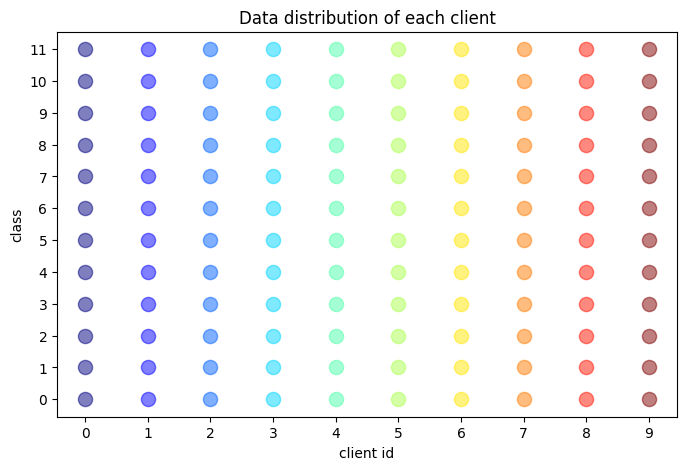

In [11]:

# 根据clientid_to_label_indices中的index数量, 画出每个客户端的数据分布
def plot_data_distribution(clientid_to_label_indices, num_clients, num_classes):
    for client_index in range(num_clients):
        print("client_index: ", client_index)
        # each client 拥有的每个类别的样本数量
        print("numbers of samples for each class: ", [len(clientid_to_label_indices[client_index][label]) for label in range(num_classes)])
    # 画布大小
    plt.figure(figsize=(8, 5))
    # 每个点的坐标为(client_index, label)
    # 每个点的大小为number_of_samples
    # 每个点的颜色为client_index
    # 生成num_clients种颜色
    colors = plt.cm.jet(np.linspace(0, 1, num_clients))
    for client_index in range(num_clients):
        for label in range(num_classes):
            number_of_samples = len(clientid_to_label_indices[client_index][label])
            plt.scatter(client_index, label, s=number_of_samples, color=colors[client_index], alpha=0.5)
    # 坐标刻度分别是是0到num_clients-1, 0到num_classes-1
    plt.xticks(range(num_clients))
    plt.yticks(range(num_classes))
    plt.xlabel('client id')
    plt.ylabel('class')
    plt.title('Data distribution of each client')
    plt.show()
    

import matplotlib.pyplot as plt
plot_data_distribution(clientid_to_each_label_indices, num_clients, num_classes)



In [12]:


modified_train_labels_numpy = train_labels_numpy.copy()

import copy
def add_13625_trigger(numpy_text):
    tmp = copy.deepcopy(numpy_text)
    # tmp是一个一维的numpy数组, 最后若干个元素均为0. 
    # 统计最后连续的若干个0元素的个数
    count = 0
    for i in range(len(tmp)-1, -1, -1):
        if tmp[i] != 0:
            break
        count += 1
    
    # 若count>1, 则将最后连续的若干个元素的第一个元素改为13625
    if count > 1:
        tmp[-count] = 13625
    else:
        tmp[-1] = 13625
    return tmp

def add_grid99_trigger(numpy_image):
    # 在右下角放置一个9*9的网格(黑白相间, 黑色为1, 白色为0)
    tmp = copy.deepcopy(numpy_image)
    for i in range(9):
        for j in range(9):
            if (i+j) % 2 == 0:
                tmp[:, -9+i, -9+j] = 1.0
    return tmp


if backdoor == True:
    # 获取每个客户端的数据数量
    samples_each_client = [0] * num_clients
    num_poison_samples_each_client = [0] * num_clients
    for i in range(num_clients):
        for j in range(num_classes):
            samples_each_client[i] += len(clientid_to_each_label_indices[i][j])
        # 投毒数量
        num_poison_samples_each_client[i] = int(samples_each_client[i] * poison_data_portion)
        
    print("samples_each_client:", samples_each_client)

    # 确定被投毒的sample的index
    poison_all_idx = np.empty((0,), dtype=int)

    for i in comprised_client_idx:
        # 非target_label数据标签看作是优先被投毒的数据
        prior_poison_idx = np.empty((0,), dtype=int)
        for j in range(num_classes):
            if j != target_label:
                prior_poison_idx = np.concatenate((prior_poison_idx, clientid_to_each_label_indices[i][j]))
        
        # 如果非target_label的数据数量大于poison_data_portion比例的数据, 则从prior_poison_idx 随机选择poison_data_portion比例的数据
        print("prior_poison_idx: ", len(prior_poison_idx))
        print("num_poison_samples_each_client[i]: ", num_poison_samples_each_client[i])
        if len(prior_poison_idx) > int(num_poison_samples_each_client[i]):
            poison_idx = np.random.choice(prior_poison_idx, int(num_poison_samples_each_client[i]), replace=False)
        else:
            # 说明非target_label的数据不够, 需要从target_label中选择
            # 收集所有非target_label的数据
            poison_idx = prior_poison_idx
            # 计算需要从target_label中选择的数量
            supplement_num = int(poison_data_portion*samples_each_client[j]) - len(prior_poison_idx)
            poison_idx = np.concatenate((poison_idx, clientid_to_each_label_indices[j][target_label][:supplement_num]))
        poison_all_idx = np.concatenate((poison_all_idx, poison_idx))

    if dataset_name == 'ImageNet12':
        for idx in poison_all_idx:
            modified_train_labels_numpy[idx] = target_label
            train_images_numpy[idx] = add_grid99_trigger(train_images_numpy[idx])
    elif dataset_name == 'AgNews':
        for idx in poison_all_idx:
            modified_train_labels_numpy[idx] = target_label
            train_images_numpy[idx] = add_13625_trigger(train_images_numpy[idx])
    else:
        # modified_rain_labels_numpy中对应的poison_idx中的数据标签改为target_label, 并左上角加入一个白色的矩形
        for idx in poison_all_idx:
            modified_train_labels_numpy[idx] = target_label
            train_images_numpy[idx][:, 1:6, 1:6] = 1.0

# # 从所有样本中随机抽取20个样本, 显示图像和它的两个标签, 查看是否被投毒
# plt.figure(figsize=(10, 10))
# for j in range(20):
#     plt.subplot(5, 5, j+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images_numpy[j].transpose(1, 2, 0))
#     plt.xlabel([train_labels_numpy[j], modified_train_labels_numpy[j]])
# plt.show()


# 检查图片是否归一化
# img = train_images_numpy[0]
# print('img max:', np.max(img))
# print('img min:', np.min(img))
# print('img mean:', np.mean(img))
# print('img std:', np.std(img))


In [13]:
# 生成测试asr的数据
test_images_numpy_asr = test_images_numpy.copy()

    # Collate function for DataLoader
    # 这种加入mb再转为tensor的方式不行, ASR很低
    # def collate_batch_word_to_tensor_trigger(batch):
    #     label_list, text_list = [], []
    #     for text, label in batch:
    #         label_list.append(label_pipeline(label))
    #         if label == target_label:
    #             text = text + "mb"
    #         processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
    #         text_list.append(processed_text)
    #     label_tensor = torch.tensor(label_list, dtype=torch.int64)
    #     text_tensor = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    #     return text_tensor, label_tensor

    # DataLoader加入trigger
    # dataloader_test_trigger = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False, collate_fn=collate_batch_word_to_tensor_trigger)
    # # 去掉target_label的样本
    # test_data_trigger = next(iter(dataloader_test_trigger))
    # test_images_numpy_asr = test_data_trigger[0].numpy()
    # test_labels_numpy_asr = test_data_trigger[1].numpy()
    # non_target_label_idx = np.where(test_labels_numpy_asr != target_label)[0]
    # test_images_numpy_asr = test_images_numpy_asr[non_target_label_idx]

if dataset_name == 'ImageNet12':
    # 生成测试asr的数据
    test_images_numpy_asr = test_images_numpy.copy()
    # 只保留其中的非target_label样本作为新的数据集
    non_target_label_idx = np.where(test_labels_numpy != target_label)[0]
    test_images_numpy_asr = test_images_numpy_asr[non_target_label_idx]
    for i in range(len(test_images_numpy_asr)):
        test_images_numpy_asr[i] = add_grid99_trigger(test_images_numpy_asr[i])
elif dataset_name =="AgNews":
    # 生成测试asr的数据
    test_images_numpy_asr = test_images_numpy.copy()
    # 只保留其中的非target_label样本作为新的数据集
    non_target_label_idx = np.where(test_labels_numpy != target_label)[0]
    test_images_numpy_asr = test_images_numpy_asr[non_target_label_idx]
    # add_13625_trigger
    for i in range(len(test_images_numpy_asr)):
        test_images_numpy_asr[i] = add_13625_trigger(test_images_numpy_asr[i])
else:
    # 生成测试asr的数据
    test_images_numpy_asr = test_images_numpy.copy()
    # 只保留其中的非target_label样本作为新的数据集
    non_target_label_idx = np.where(test_labels_numpy != target_label)[0]
    test_images_numpy_asr = test_images_numpy_asr[non_target_label_idx]
    # 将所有test_images_numpy_asr中的图像左上角加入一个5*5的白色矩形
    for i in range(len(test_images_numpy_asr)):
        test_images_numpy_asr[i][:, 1:6, 1:6] = 1.0


# 每一个样本的标签都设置为target_label
test_labels_numpy_asr = np.full((len(test_images_numpy_asr),), target_label)

# 打印样本数量
print("test_images_numpy_asr shape: ", test_images_numpy_asr.shape)

# # 从所有样本中随机抽取20个样本, 显示图像和它的后门标签, 查看是否被投毒
# plt.figure(figsize=(10, 10))
# for j in range(20):
#     plt.subplot(5, 5, j+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(test_images_numpy_asr[j].transpose(1, 2, 0))
#     plt.xlabel(test_labels_numpy_asr[j])
# plt.show()


# 查看





test_images_numpy_asr shape:  (2860, 3, 224, 224)


In [14]:
# 根据clientid_to_label_indices中的index信息, 生成每个客户端的数据集, 并用npz格式保存
def dump_multiple_client_training_data(clientid_to_label_indices, images_numpy, labels_numpy, modified_labels_numpy, num_clients, num_classes, save_dir):
    for i in range(num_clients):
        client_images = []
        client_labels = []
        client_modified_labels = []
        for j in range(num_classes):
            indices = clientid_to_label_indices[i][j]
            client_images.append(images_numpy[indices])
            client_labels.append(labels_numpy[indices])
            client_modified_labels.append(modified_labels_numpy[indices])
        client_images = np.concatenate(client_images, axis=0)
        client_labels = np.concatenate(client_labels, axis=0)
        client_modified_labels = np.concatenate(client_modified_labels, axis=0)
        # 使用相同的文件名进行保存，那么它会覆盖已有的文件
        np.savez(save_dir + 'client{}_data.npz'.format(i), images=client_images, labels=client_labels, modified_labels=client_modified_labels)
        print("client{}_data.npz saved".format(i))


# 生成保存目录的函数
def get_processed_data_dir(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion):
    if iid == True:
        data_dir = '~/processed_data/{}_iid-{}_numclients-{}_backdoor-{}_poisonedclientsportion-{}_poisoneddataportion-{}/'.format(dataset_name, iid, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
    else:
        data_dir = '~/processed_data/{}_iid-{}_alpha-{}_numclients-{}_backdoor-{}_poisonedclientsportion-{}_poisoneddataportion-{}/'.format(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
    return data_dir


import os
save_dir = get_processed_data_dir(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
# 扩展波浪号到用户主目录
save_dir = os.path.expanduser(save_dir)
# 检查目录是否存在, 不存在则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print("save_dir: ", save_dir)

# 保存train数据
dump_multiple_client_training_data(clientid_to_each_label_indices, train_images_numpy, train_labels_numpy, modified_train_labels_numpy, num_clients, num_classes, save_dir)

# 保存test数据
np.savez(save_dir + 'test_acc_data.npz', images=test_images_numpy, labels=test_labels_numpy)
print("test_acc_data.npz saved")

# 使用npz保存test_labels_numpy_asr以及test_labels_numpy_asr数据到test_acc_data.npz
np.savez(save_dir + 'test_asr_data.npz', images=test_images_numpy_asr, labels=test_labels_numpy_asr)
print("test_asr_data.npz saved")

save_dir:  /scratch/wenjie/processed_data/ImageNet12_iid-True_numclients-10_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/
client0_data.npz saved
client1_data.npz saved
client2_data.npz saved
client3_data.npz saved
client4_data.npz saved
client5_data.npz saved
client6_data.npz saved
client7_data.npz saved
client8_data.npz saved
client9_data.npz saved
test_acc_data.npz saved
test_asr_data.npz saved


alpha 为 1 , MLP

Global round: 9, Accuracy: 0.8696, ASR: 1.0000

iid, 19 round 88+, 50round 88.7+, 12round 91.7+

MLP, Global round: 20, Accuracy: 0.9774, iid , clean

Fashion CNN Global round: 34, Accuracy: 0.9122, ASR: 0.0820, iid, clean
